<a href="https://colab.research.google.com/github/zhaoyangbu/ML-study/blob/main/ResNetDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install torch

In [4]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.4 MB/s 


In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 1. Residual Block
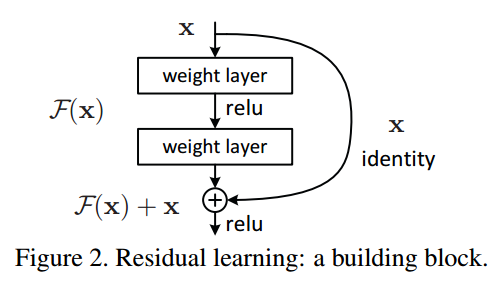
#### F(x) is the Residual Function, x is the shortcut. 
#### ⊕ represents element-wise addition, which means the size of F(x) and identity x must be the same.
#### For examle:
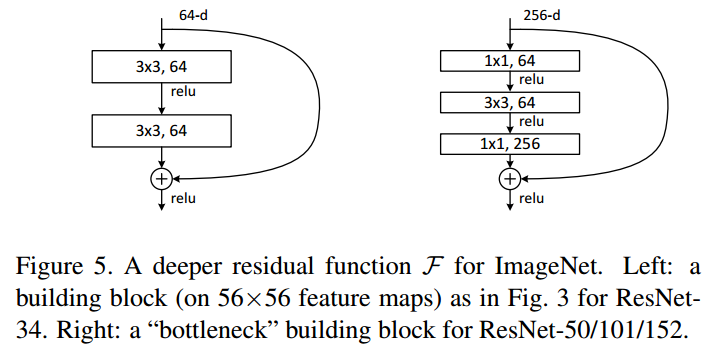
### 1. Two types of blocks: Basic Block and Bottleneck Block
#### Main difference: size of conv layer
#### Why using Bottle Neck？-- save cal time
#### Num of Params: （assume dim = 256）
#### Basic: （256x3x3x256）x 2 = 1179648
#### BottleNeck: （256x1x1x64）+（64x3x3x64）+（64x1x1x256）= 69632

In [6]:
class Residual(nn.Module): 
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels) # make feature map mean = 0, var = 1
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

### 2. Shortcut
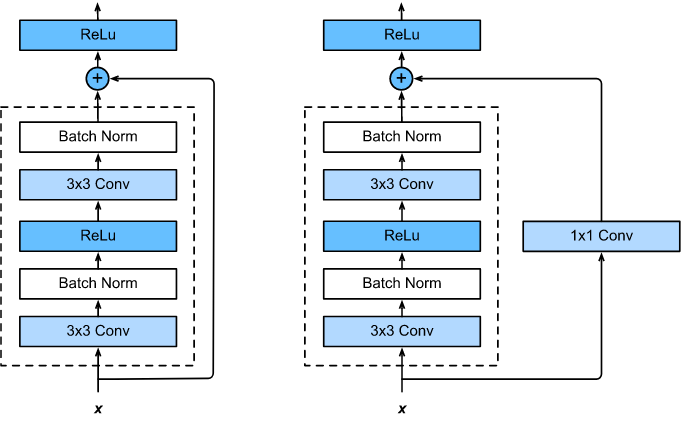
#### left: take x identity as output directly
#### right: x through 1x1 conv layer (aim: in(de)crease its dim to keep same dim)

In [7]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

Pytorch using N C H W
 
 N: batch size
 
 C: channel
 
 H: height
 
 W: width

For height:

6--conv1(k=3,p=1,s=1)=(6-(3-1)+2*1-1)/1+1=6

6--conv1(k=3,p=1,s=1) = 6

So outputsize = [4, 3, 6, 6]


In [11]:
X = torch.rand(4, 3, 6, 6)
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

6--conv3(k=1,s=2)=(6-(1-1)+2*0)/2+1 = 3

In [12]:
# Build the First Block (7 x 7 conv layer)
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [13]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [14]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [15]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [17]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.022, train acc 0.993, test acc 0.893
369.4 examples/sec on cuda:0


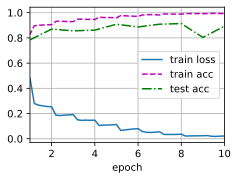

In [18]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# CP-ResNet

- What is Receptive Field:

    Sn=Sn−1∗sn 

    RFn =RFn−1 +(kn −1)∗Sn 

            sn: stride

            Sn: cumulatative stride

            Kn: kernel size

            RFn: RF of unit from layer n to input


- Basic idea:
    Filter size at different CNN levels: xk ∈ {1, 3} 
    
    Hyperparameter rho --decide--> filter size --decide--> RF 
 
    xk = 3 if k =< rho
    
    xk = 1 if k > rho
